<a href="https://colab.research.google.com/github/jsrobson/2023-cis5450-termproject/blob/main/CIS5450_TermProject_03_compose_data_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: Data composing
*Description:* This notebook contains code to collate, clean, and compile a project dataset `df_lsoa_reduced` from distinct data sources. This dataset will be the basis of further work in other notebooks. To create this dataset, we will integrate datasets:
* condensed STR listings (86,359 rows; sourced from [Inside Airbnb](http://insideairbnb.com/explore/))
* attribute-linked property price paid and environmental performance (57,719 rows; sourced from [University College London / UK Data Service](https://reshare.ukdataservice.ac.uk/854942/))
* English Indices of Deprivation 2019 for Greater London (4,836 rows; sourced from [London Datastore/UK Government](https://data.london.gov.uk/dataset/indices-of-deprivation)).

By section, the general workflow of this notebook is:
1. Initialization
2. Load and clean data
3. Data summary and collation

*Data:* The resulting project dataset `df_lsoa_reduced` is focused on summary information derived from the above datasets and is organized at the Lower-layer Super Output Area (LSOA) geographic scale. LSOA are defined as "homogenous small areas of relatively even size containing approximately 1,500 people" ([UK MHCLG, 2019, 13](https://assets.publishing.service.gov.uk/media/5d8b364ced915d03709e3cf2/IoD2019_Research_Report.pdf)). The most recent update to LSOA boundaries based on population change took place in 2011.

We use the LSOA geographic scale rather than the more conventional borough scale as it provides an opportunity to introduce a sufficient amount of complexity into the dataset by focusing on a more fine-grained geographic scale. To illustrate this, Greater London comprises 32 boroughs and the City of London. In contrast, there are 4,835 LSOA in the same area. Through this notebook, we will narrow the focus and number of LSOA to an inner London survey area.

*Return:* The resulting project dataset `df_lsoa_reduced` will be used as input to further exploratory data analysis and modelling tasks performed in companion project notebooks.



# 1. Initialization
*Description:* In this section, we import libraries, initialize filepaths, and reuse predefined dataloader functions from [Load Data](https://colab.research.google.com/drive/1MXdBZLM5Yw3anvdrP-qozn7MHs_6SzDw?usp=sharing) notebook.

To begin, we install a Python package to convert standard latitude, longitude coordinates (World Geodetic System 1984 [link text](https://en.wikipedia.org/wiki/World_Geodetic_System), WGS84) to coordinates used in the [Ordinance Survey National Grid](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid) reference system (OSGB). Listing instances in listing dataset are represented as WGS84 coordinates but the shapefiles used for mapping are represented as polygons using OSGB format. We use the [bng-lat-lon](https://pypi.org/project/bng-latlon/) Python package to resolve this mismatch of coordinate systems.

In [ ]:
# install packages to convert lat, long values to Ordinance Survey National Grid
!pip install bng-latlon
!pip install numba

  Preparing metadata (setup.py) ... done
  Created wheel for bng-latlon: filename=bng_latlon-1.1-py3-none-any.whl size=8257 sha256=0f645cf98e452acd51c744bb02e95d2b10e570b2b74ebd11bbd918b4aabbaf16
  Stored in directory: /root/.cache/pip/wheels/e5/76/63/0e4e8e76dc96c95a7b23dc18498384ef5b2a3affbd9c20a48a
Successfully built bng-latlon


In [ ]:
# import necessary libraries
from dask import dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from bng_latlon import WGS84toOSGB36

In [ ]:
# mount Google Drive for data access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Load and clean data
*Description*: In this section, we load and clean the constituent datasets for further workflow in the notebook.

We first generate the necessary filepaths for project data from the mounted Google Drive location. Then, we borrow from our [Load Data](https://colab.research.google.com/drive/1MXdBZLM5Yw3anvdrP-qozn7MHs_6SzDw?usp=sharing) notebook several pre-defined functions used to instantiate the necessary project data as practical data objects (as lists, dataframes).

Following data instantiation, we will shift focus towards handling geographic forms of data by delimiting a London boundary LSOA shapefile to the inner London survey area and by mapping STR listing coordinates included in the `listings` dataset to specified coordinates on the shapefile.

*Data*: This section will draw upon the following datasets:

* LSOA 2011 boundary shapefile for Greater London [(GLA, 2019)](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)
* CSV of London boroughs categorized by binary `inner/outer` position. Borough names were derived from [borough council tax data](https://data.london.gov.uk/dataset/council-tax-charges-bands-borough), while geographic location was informed by definition in the London Government Act 1963 as described by [Wikipedia](https://en.wikipedia.org/wiki/Inner_London). Note that while City of London and Newham are not officially recognized as boroughs of Inner London, for common statistical purposes, we include both.
* Attribute-linked property price paid and environmental performance data, as defined above, and
* Condensed STR listings, as defined above.

*Return*: A geographic dataframe `pointInPoly`, which is constructed from a spatial join of listings point instances and LSOA boundary shapefiles for inner London. This will form the basis of further exploratory analytic and collation work performed in the following section.

In [ ]:
# initialize filepaths from mounted Google Drive for reference
sf_path = "/content/drive/MyDrive/CIS5450/Term_Project/data/shapefile/LSOA_2011_London_gen_MHW.shp"
br_path = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_borough/ldn_borough.csv"
pr_path = "/content/drive/MyDrive/CIS5450/Term_Project/data/uk_property/uk_epdc_prop.csv"
lt_path = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_airbnb/listings_cond.csv"

In [ ]:
# helper function used to read listings to df, predefined in data loader notebook
def read_listings_to_df(filepath):
    # assign dtypes to each column
    d_listing = {
        "id": "int32",
        "name": "string",
        "host_id": "int32",
        "host_name": "string",
        "neighbourhood_group": "string",
        "neighbourhood": "string",
        "latitude": "float",
        "longitude": "float",
        "room_type": "string",
        "price": "float",
        "minimum_nights": "int32",
        "number_of_reviews": "int32",
        "last_review": "string",
        "reviews_per_month": "float",
        "calculated_host_listings_count": "int32",
        "availability_365": "int32",
    }
    # read csv using dtype dict
    file_in = pd.read_csv(filepath, dtype=d_listing)
    return parse_listings_df(file_in)


def parse_listings_df(dataframe):
    # rename column for common alignment
    dataframe.rename(inplace=True, columns={'neighbourhood': 'borough'})
    # convert last_review as date/time
    dataframe['last_review'] = pd.to_datetime(dataframe['last_review'],format='%Y-%m-%d')
    # build array of columns to drop
    to_drop = ['name', 'host_name', 'neighbourhood_group']
    # drop specified columns from listings
    dataframe.drop(axis=1, columns=to_drop, inplace=True)
    return dataframe

In [ ]:
# helper function used to read London boroughs to list, predefined in data loader notebook
def read_boroughs_to_list(filepath):
    # read file
    file_in = pd.read_csv(filepath, dtype={"neighbourhood": "str"})
    # filter by inner boroughs
    file_in = file_in[file_in['location'] == 'inner']
    # return boroughs as list
    return file_in['neighbourhood'].values.tolist()

In [ ]:
# helper function used to read properties to df, predefined in data loader notebook
def read_epdc_prop_to_df(filepath):
    # use dask for multiprocessor csv reading support
    file_in = dd.read_csv(filepath, dtype="string")
    # return a pandas df using parsing helper method
    return parse_epdc_prop_df(file_in)

def parse_epdc_prop_df(df):
    # define cols to cast to int
    cols_int = ['id', 'price', 'year', 'numberrooms',
                'BUILDING_REFERENCE_NUMBER']
    # define cols to drop (mostly redundant, unneeded, or artefact)
    to_drop = ['Unnamed: 0', 'towncity', 'county', 'lad11nm', 'rgn11nm',
               'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL']
    # convert dask df to pandas df
    pd_df = df.compute()
    # drop specified cols from df
    pd_df.drop(axis=1, columns=to_drop, inplace=True)
    # for each col in df, attempt to convert to numeric value
    for col in pd_df.columns:
        # convert to numeric format generally
        pd_df[col] = pd.to_numeric(pd_df[col], errors='ignore')
        # if column targeted as integer
        if col in cols_int:
            # convert to int rather than float
            pd_df[col] = pd_df[col].astype(int)
    # convert district column to title case
    pd_df['district'] = pd_df['district'].str.title()
    # get (cost / floor area) ratio for each row and round to two dec points
    pd_df['cost_fl_area'] = round(pd_df['price']/pd_df['tfarea'], 2)
    return pd_df

**Read shapefile data:** Using the statistical geographic information system (GIS) boundary files for Greater London, we read Lower-layer Super Output Areas (LSOA) 2011 boundaries as a shapefile using the [geopandas](https://geopandas.org/en/stable/) library. We select the LSOA as our preferred geographic unit of analysis as their number will provide suitable scale for analysis; the number of higher-level survey boroughs (14) are too few for effective analysis.

In [ ]:
# get LSOA-level shapefile data
g_data = gpd.read_file(sf_path)
# print first 2 to understand shape
g_data.head(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."


In [ ]:
# get count of LSOA in Greater London for reference
lsoa_gl = len(g_data)
print(lsoa_gl)

4835


In [ ]:
# print unique value counts to see names of boroughs, we will select for inner London
g_data['LAD11NM'].value_counts()

Croydon                   220
Barnet                    211
Bromley                   197
Ealing                    196
Enfield                   183
Wandsworth                179
Lambeth                   178
Brent                     173
Lewisham                  169
Southwark                 166
Newham                    164
Redbridge                 161
Hillingdon                161
Greenwich                 151
Havering                  150
Bexley                    146
Haringey                  145
Waltham Forest            144
Tower Hamlets             144
Hackney                   144
Hounslow                  142
Harrow                    137
Camden                    133
Westminster               128
Merton                    124
Islington                 123
Sutton                    121
Richmond upon Thames      115
Hammersmith and Fulham    113
Barking and Dagenham      110
Kensington and Chelsea    103
Kingston upon Thames       98
City of London              6
Name: LAD1

**Prune shapefile extent:** We will now condense our shapefile extent to the specified Inner London boroughs and the City of London. First, we output the extent of Greater London LSOA as a visualization to confirm the shapefile is behaving as expected. We will then generate a filtered list of our survey boroughs and use this as the basis to drop unnecessary LSOA outside of our immediate study area.

<Figure size 1280x960 with 0 Axes>

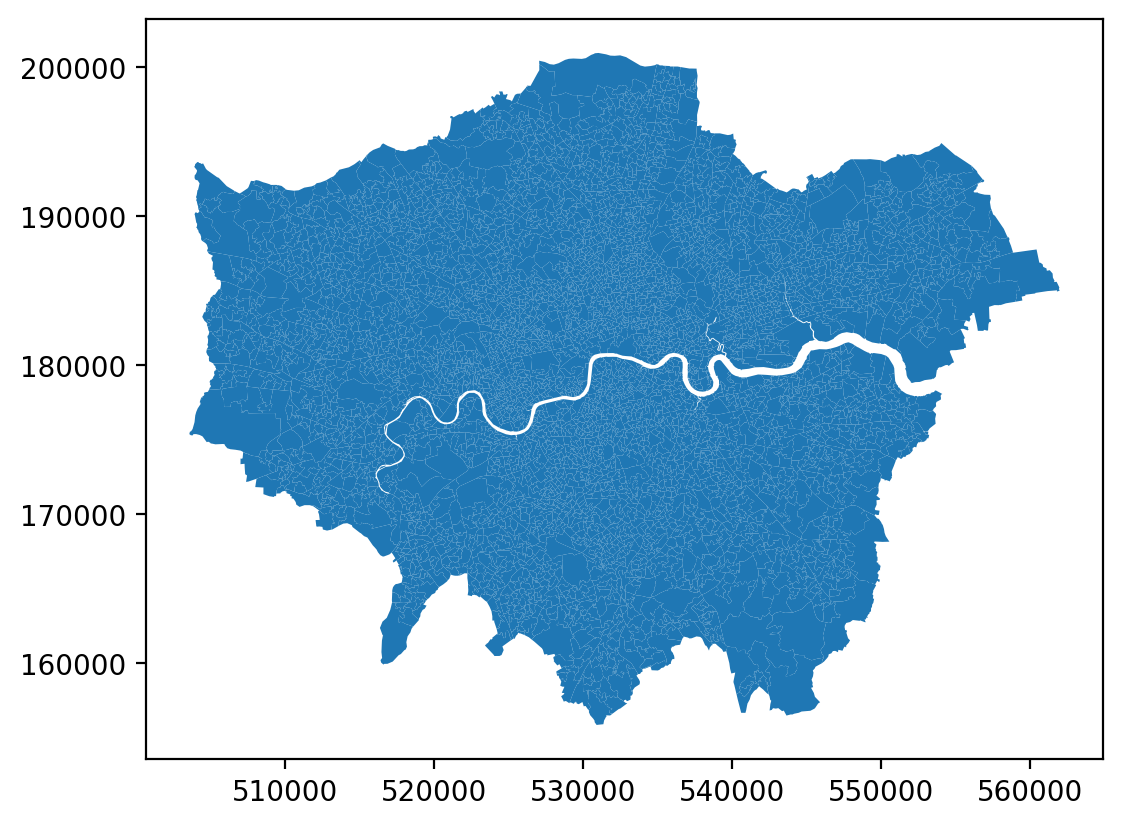

In [ ]:
# BUILD MAP FOR STR BY LSOA (GREATER LONDON)
# set figure dimensions
plt.rcParams['figure.dpi'] = 200
plt.tight_layout()

# plot boundary lines for boroughs
g_data.plot()
plt.show()

In [ ]:
# get list of boroughs using helper function
boroughs = read_boroughs_to_list(br_path)
print("Preliminary list: ", boroughs)
# modify borough list to use as filter for LSOA shapefile
borough_filter = list(map(lambda b: "Westminster" if b == "City of Westminster" else b, boroughs))
print("Modified list, for Westminster: ", borough_filter)

Preliminary list:  ['Camden', 'City of London', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Newham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'City of Westminster']
Modified list, for Westminster:  ['Camden', 'City of London', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Newham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'Westminster']


In [ ]:
# filter geographic data based on inner London boroughs in filtered list
f_data = g_data[g_data['LAD11NM'].isin(borough_filter)]

<Figure size 1280x960 with 0 Axes>

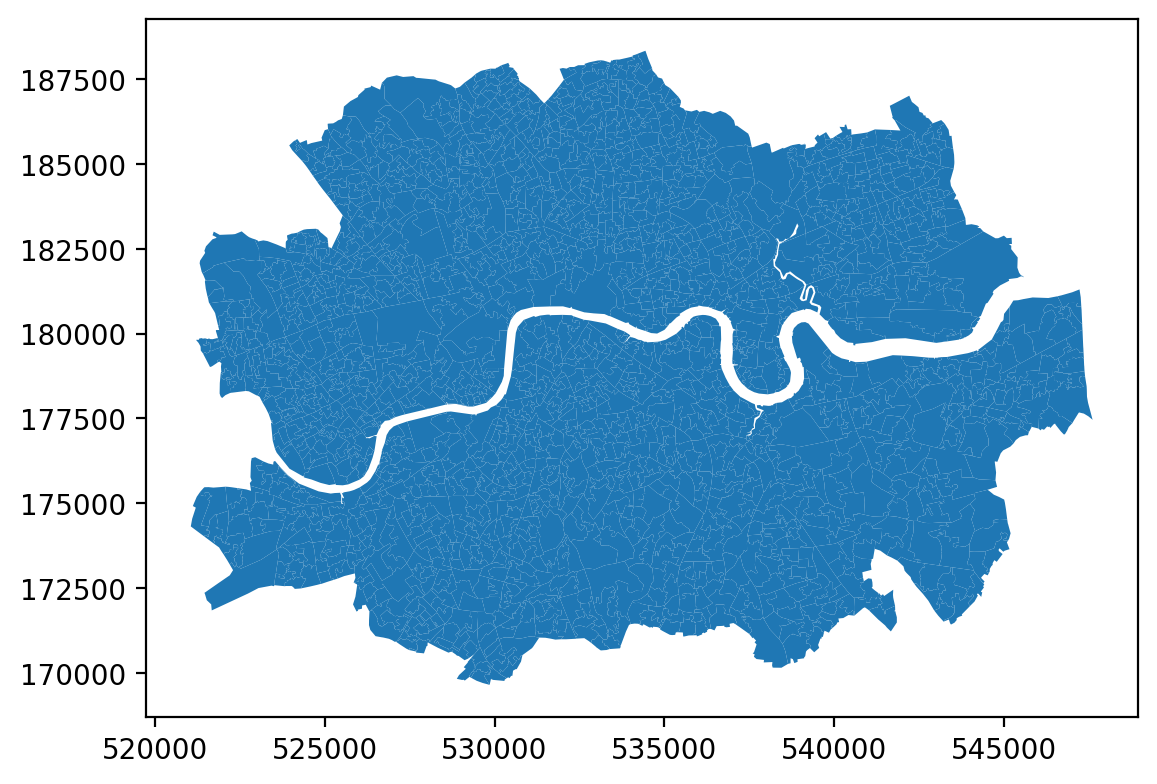

In [ ]:
# BUILD MAP FOR STR BY LSOA (INNER LONDON)
# set figure dimensions
plt.rcParams['figure.dpi'] = 200
plt.tight_layout()

# plot boundary lines for boroughs
f_data.plot()
plt.show()

**Dataset loading:** Now we will load in the `listings` and `properties` dataframes from associated STR listing and attribute-linked price paid property datasets, respectively. The `properties` dataset includes a `lsoa11` feature that we will use to assign each property to its respective LSOA.

Unfortunately, the `listings` dataset includes no such feature. We will instead use the WGS84 `latitude`, `longitude` values associated with each listing instance to generate their LSOA membership using the [shapely](https://shapely.readthedocs.io/en/stable/manual.html) Python library.

In [ ]:
# get str listings from corresponding dataset
listings = read_listings_to_df(lt_path)
# filter listings by inner London boroughs
listings = listings[listings['borough'].isin(borough_filter)]
# print first 2 to understand shape
listings.head(2)

,id,host_id,borough,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,13913,54730,Islington,51.56802,-0.11121,Private room,65.0,1,21,2020-02-22,0.18,2,359
1,15400,60302,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100.0,10,89,2020-03-16,0.71,1,232


In [ ]:
# get properties df from corresponding dataset
properties = read_epdc_prop_to_df(pr_path)
# print first 2 to understand shape
properties.head(2)

,id,transactionid,oa11,postcode,price,dateoftransfer,propertytype,oldnew,duration,paon,...,LIGHTING_ENV_EFF,MAIN_FUEL,WIND_TURBINE_COUNT,HEAT_LOSS_CORRIDOOR,UNHEATED_CORRIDOR_LENGTH,FLOOR_HEIGHT,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,cost_fl_area
0,12186,{79A74E22-352D-1289-E053-6B04A8C01627},E00171041,SW11 8NJ,445000,2018-10-01,F,N,L,"WARWICK BUILDING, 366",...,Very Poor,electricity (not community),0,no corridor,NaN,NaN,NaN,N,natural,9468.09
1,12863,{7E86B6FB-5F2C-458C-E053-6B04A8C0C84C},E00171047,SW11 8NP,580000,2018-10-17,F,N,L,"THE BRIDGE, 334",...,Very Poor,electricity (not community),0,unheated corridor,6.9,NaN,NaN,N,natural,8055.56


**Generate property count for each LSOA:** We will count the number of properties in the `property` dataframe in each LSOA within our study area. These will be stored in a "narrow" dataframe called `lsoa_properties` for the time being.

In [ ]:
# count properties by LSOA area and save as series
lsoa_properties = properties.groupby(['lsoa11'], observed=True)['id'].count()
# convert series to frame
lsoa_properties = lsoa_properties.to_frame()
# rename col
lsoa_properties.rename(columns={"id":"count"}, inplace=True)
# get sum of all properties and print as sanity check
sum_prop = lsoa_properties['count'].sum()
print("Sum of properties in all inner London LSOA: ", sum_prop)

Sum of properties in all inner London LSOA:  57718


**Allocate listings to LSOA:** Now we focus on deriving LSOA membership for each listing in the `listings` dataframe. First, we get the coordinate reference system (CRS) for the LSOA shapefile for inner London. Then, we will convert the WGS84 `latitude`, `longitude` values for each listing in `listings` to their corresponding OSGB coordinate values using the [bng-lat-lon](https://pypi.org/project/bng-latlon/) Python package.

With the converted coordinates in place, we will generate point geometry and convert our `listings` dataframe to a geographic dataframe using [geopandas](https://geopandas.org/en/stable/), assign the appropriate CRS to match our LSOA shapefile `f_data`, and plot a cartographic visualization of listing points atop the LSOA shapefile to ensure our process has functioned as expected.

In [ ]:
# get coordinate reference system for LSOA shapefile
shp_crs = f_data.crs
print(shp_crs)

PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [ ]:
# get OSGB equivalent coordinates for WGS84 lat, long using function WGS84toOSGB36
listings[['os_lat', 'os_lon']] = listings.apply(lambda row: pd.Series(WGS84toOSGB36(row['latitude'], row['longitude'])), axis=1)

In [ ]:
# print two listings to see OSGB coordinate addition
listings.head(2)

,id,host_id,borough,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,os_lat,os_lon
0,13913,54730,Islington,51.56802,-0.11121,Private room,65.0,1,21,2020-02-22,0.18,2,359,531005.9704,187150.8439
1,15400,60302,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100.0,10,89,2020-03-16,0.71,1,232,527225.1219,178145.9959


In [ ]:
# generate point geometry object using shapely and OS lat, long
geometry = [Point(lat, lon) for lat, lon in zip(listings['os_lat'], listings['os_lon'])]
# generate point geodataframe using CRS
gdf_points = gpd.GeoDataFrame(listings, geometry=geometry, crs=shp_crs)
# print two rows to observe df
gdf_points.head(2)

,id,host_id,borough,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,os_lat,os_lon,geometry
0,13913,54730,Islington,51.56802,-0.11121,Private room,65.0,1,21,2020-02-22,0.18,2,359,531005.9704,187150.8439,POINT (531005.970 187150.844)
1,15400,60302,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100.0,10,89,2020-03-16,0.71,1,232,527225.1219,178145.9959,POINT (527225.122 178145.996)


In [ ]:
# return evaluation of CRS matches
print("CRS for gdf_points matches CRS for LSOA shapefile: ", gdf_points.crs == shp_crs)

CRS for gdf_points matches CRS for LSOA shapefile:  True


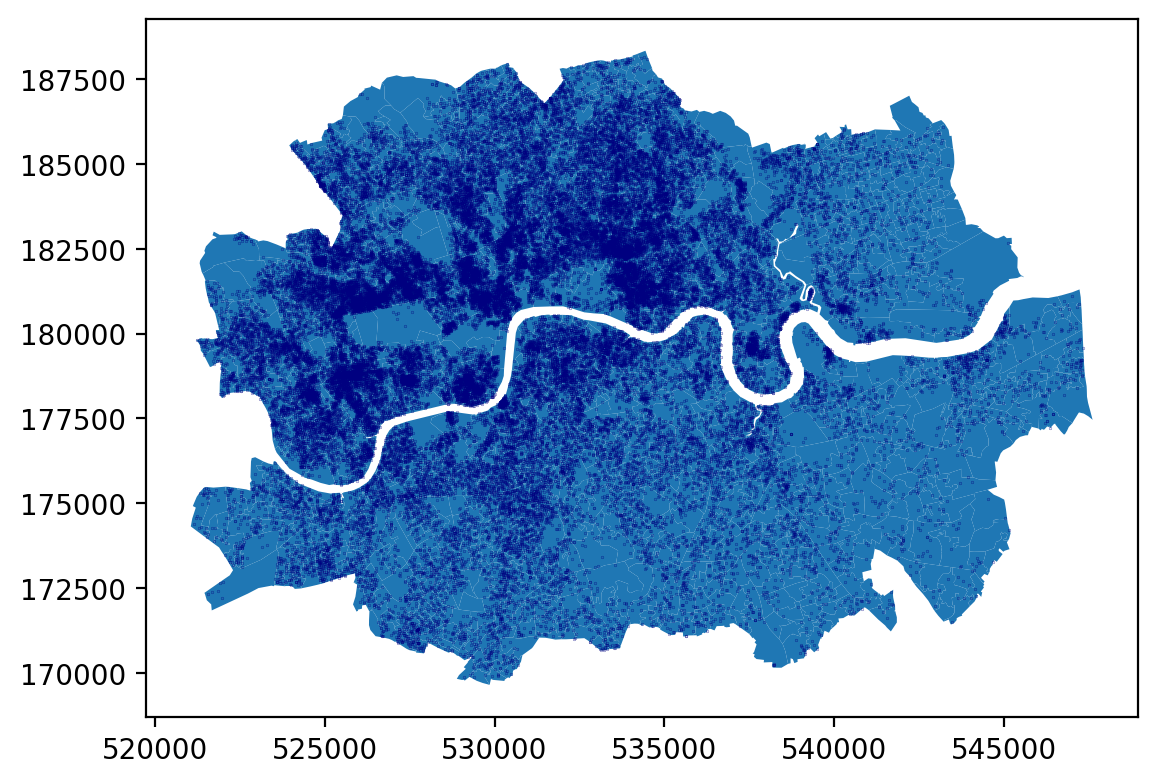

In [ ]:
# output points-shape map to ensure anticipated behaviour
f_data.plot()
gdf_points.plot(marker=".", color="navy", markersize=0.05, ax=plt.gca())
plt.show()

**Brief digression for geographic analysis:** From the above cartographic output, we generally observe a density of STR properties north of the river Thames in the centre and west of inner London. The observed gap at the centre of the map is representative of the non-residential land uses in the [City of London](https://en.wikipedia.org/wiki/City_of_London) while those gaps in the west represent longstanding reserved green spaces and ceremonial institutional lands. From north to south we see: [Hampstead Heath](https://en.wikipedia.org/wiki/Hampstead_Heath), [Regent's Park](https://en.wikipedia.org/wiki/Regent%27s_Park), [Hyde Park](https://en.wikipedia.org/wiki/Hyde_Park,_London), [Buckingham Palace](https://en.wikipedia.org/wiki/Buckingham_Palace), and [Battersea Park](https://en.wikipedia.org/wiki/Battersea_Park).

**Determine LSOA membership:** For each point geometry generated from the listing dataset, we will find the LSOA which it is within. This is performed efficiently using a [spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html) function offered by the geopandas library. We observe from our test output below that the `borough` column from `listings` matches the `LAD11NM` column from the LSOA boundary shapefile `f_data` as we might expect.

In [ ]:
# determine number of LSOA in inner London
print("Number LSOA in inner London study area: ", len(f_data))

Number LSOA in inner London study area:  1901


In [ ]:
# conduct a spatial join to allocate points to their respective LSOA home area
pointInPoly = gpd.tools.sjoin(gdf_points, f_data, predicate="within", how="left")
# observe outcome – see matching listing 'borough' and shape 'LAD11NM'
pointInPoly.head(5)

,id,host_id,borough,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,...,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ
0,13913,54730,Islington,51.56802,-0.11121,Private room,65.0,1,21,2020-02-22,...,E09000019,Islington,E12000007,London,1569.0,1569.0,0.0,122.5,758.0,2.1
1,15400,60302,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100.0,10,89,2020-03-16,...,E09000020,Kensington and Chelsea,E12000007,London,1564.0,1432.0,132.0,87.8,741.0,1.9
2,17402,67564,Westminster,51.52195,-0.14094,Entire home/apt,300.0,3,42,2019-11-02,...,E09000033,Westminster,E12000007,London,1773.0,1514.0,259.0,161.3,824.0,1.8
3,17506,67915,Hammersmith and Fulham,51.47935,-0.19743,Private room,150.0,3,0,NaT,...,E09000013,Hammersmith and Fulham,E12000007,London,1366.0,1351.0,15.0,148.0,610.0,2.2
4,25023,102813,Wandsworth,51.44687,-0.21874,Entire home/apt,65.0,21,35,2020-03-30,...,E09000032,Wandsworth,E12000007,London,1537.0,1452.0,85.0,95.0,643.0,2.3


In [ ]:
# find number of rows in matched point/poly df
print("Number of listing instances in listings df: ", len(listings))
print("Number of listing instances in pointInPoly gdf: ", len(pointInPoly))

Number of listing instances in listings df:  66771
Number of listing instances in pointInPoly gdf:  66771


#3. Data summary and collation
*Description:* In this section, we generalize our `pointInPoly` and `properties` dataframe rows by the inner London LSOA geographic areas to derive summary information respecting the count of STR listings, properties, and average pricing for STR nightly stays and average cost by property floor area. This has the effect of producing primary dependent and independent variables for further exploration and modelling.

We then introduce the [English Indices of Deprivation 2019](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019) at the LSOA geographic scale. This has the effect of introducing potential confounding independent variables into the project dataset during the modelling process.

*Data:* This section relies on the following dataframes / datasets:

*   `properties`: dataframe derived from the attribute-linked property price paid and environmental performance data, as referenced above
*   `pointInPoly`: merged geographic dataframe including listings data and LSPA boundary shapefile data filtered by an inner London extent
*   `ex_in`: dataframe read from LSOA-level English Indices of Deprivation 2019, as above. We note that the higher the score returned by the Indices of Deprivation, the more deprived the corresponding LSOA is by the specified domain.

*Return:* `df_lsoa_reduced`, a dataset produced in comma-separated values (`.csv`) format with 14 features and 1,885 rows gleaned from the above dataframes. Each row in the dataset represents an LSOA, with the below features:

```
LSOA11CD: Given LSOA code, 2011 boundaries
avg_str_price: The average price (by night) of a STR property within the LSOA
cost_fl_area: The average cost by floor area (m^2) of a property within the LSOA
count_prop: The count of properties within the LSOA boundary
count_list: The count of STR listings within the LSOA boundary
borough: The borough (local government authority) to which the LSOA is a part
imd_score: The index of multiple deprivation (cumulative) score, UK Index of Deprivation (ID)
income_score: The income deprivation score, UK ID
employ_score: The employment deprivation score, UK ID
educ_score: The education, skills and training score, UK ID
health_score: The health deprivation and disability score, UK ID
crime_score: The crime deprivation score, UK ID
house_score: The barriers to housing and services score, UK ID
env_score: The living environment score, UK ID
```

**Generate 'narrow' dataframes:** In the following section, we will generate several 'narrow' dataframes that include summary information for each LSOA. These will later be collated into a comprehensive dataframe. These are:


* `avg_str_price_lsoa`: The average price (by night) of a STR property by LSOA
* `avg_cost_fl_area_lsoa`: The average cost by floor area (m^2) of a property by LSOA
* `count_properties_lsoa`: The count of properties by LSOA
* `count_listings_lsoa`: The count of listings by LSOA



In [ ]:
# generate average STR price by LSOA area
avg_str_price_lsoa = round(pointInPoly.groupby(['LSOA11CD'], observed=True)['price'].mean(), 2)
# convert to dataframe
avg_str_price_lsoa = avg_str_price_lsoa.to_frame().reset_index()
# rename price column
avg_str_price_lsoa.rename(columns={"price":"avg_str_price"}, inplace=True)
# observe result
avg_str_price_lsoa.head(10)

,LSOA11CD,avg_str_price
0,E01000001,137.90
1,E01000002,180.87
2,E01000003,81.07
3,E01000005,128.67
4,E01000842,124.82
5,E01000843,149.86
6,E01000844,166.81
7,E01000845,113.89
8,E01000846,121.50
9,E01000847,92.00


In [ ]:
# find number of rows in LSOA dataframe we generated vs number of rows in original LSOA shapefile
print("LSOA shp for inner London rows: ", len(f_data))
print("LSOA avg_str_price df rows: ", len(avg_str_price_lsoa))
print("diff: ", len(f_data)-len(avg_str_price_lsoa))

LSOA shp for inner London rows:  1901
LSOA avg_str_price df rows:  1890
diff:  11


In [ ]:
# generate average cost per floor area by LSOA area
avg_cost_fl_area_lsoa = round(properties.groupby(['lsoa11'], observed=True)['cost_fl_area'].mean(), 2)
# convert to dataframe
avg_cost_fl_area_lsoa = avg_cost_fl_area_lsoa.to_frame().reset_index()
# rename lsoa column
avg_cost_fl_area_lsoa.rename(columns={"lsoa11":"LSOA11CD"}, inplace=True)
avg_cost_fl_area_lsoa.head(10)

,LSOA11CD,cost_fl_area
0,E01000001,13261.97
1,E01000002,14235.39
2,E01000003,13600.62
3,E01000005,8998.64
4,E01000023,5000.00
5,E01000339,5722.22
6,E01000344,4598.54
7,E01000531,6864.46
8,E01000672,4963.67
9,E01000802,3521.21


In [ ]:
# find number of rows in LSOA dataframe we generated vs number of rows in original LSOA shapefile
print("LSOA shp for inner London rows: ", len(f_data))
print("LSOA avg_cost_fl_area_lsoa df rows: ", len(avg_cost_fl_area_lsoa))
print("diff: ", len(f_data)-len(avg_cost_fl_area_lsoa))

LSOA shp for inner London rows:  1901
LSOA avg_cost_fl_area_lsoa df rows:  1910
diff:  -9


In [ ]:
# get count of properties by LSOA
count_properties_lsoa = properties.groupby(['lsoa11'], observed=True)['id'].count()
# convert to dataframe
count_properties_lsoa = count_properties_lsoa.to_frame().reset_index()
# rename lsoa, id column
count_properties_lsoa.rename(columns={"lsoa11":"LSOA11CD", "id": "count_prop"}, inplace=True)
count_properties_lsoa.head(10)

,LSOA11CD,count_prop
0,E01000001,40
1,E01000002,27
2,E01000003,99
3,E01000005,7
4,E01000023,1
5,E01000339,1
6,E01000344,1
7,E01000531,2
8,E01000672,5
9,E01000802,1


In [ ]:
# find number of rows in LSOA dataframe we generated vs number of rows in original LSOA shapefile
print("LSOA shp for inner London rows: ", len(f_data))
print("LSOA count_properties_lsoa df rows: ", len(count_properties_lsoa))
print("diff: ", len(f_data)-len(count_properties_lsoa))

LSOA shp for inner London rows:  1901
LSOA count_properties_lsoa df rows:  1910
diff:  -9


In [ ]:
# generate count of listings by LSOA area
count_listings_lsoa = pointInPoly.groupby(['LSOA11CD'], observed=True)['id'].count()
# convert to dataframe
count_listings_lsoa = count_listings_lsoa.to_frame().reset_index()
# rename price column
count_listings_lsoa.rename(columns={"id":"count_list"}, inplace=True)
# observe result
count_listings_lsoa.head(10)

,LSOA11CD,count_list
0,E01000001,10
1,E01000002,15
2,E01000003,14
3,E01000005,64
4,E01000842,34
5,E01000843,29
6,E01000844,32
7,E01000845,44
8,E01000846,16
9,E01000847,15


In [ ]:
# find number of rows in LSOA dataframe we generated vs number of rows in original LSOA shapefile
print("LSOA shp for inner London rows: ", len(f_data))
print("LSOA count_properties_lsoa df rows: ", len(count_listings_lsoa))
print("diff: ", len(f_data)-len(count_listings_lsoa))

LSOA shp for inner London rows:  1901
LSOA count_properties_lsoa df rows:  1890
diff:  11


**Merge dataframes:** In this section, we merge the 'narrow' dataframes generated in the previous section and introduce the Indices of Deprivation data `ex_id` which itself will be merged by LSOA code. The resulting dataframe `df_lsoa` is cleaned, pruned, and otherwise prepared for output and later use.

In [ ]:
# create a merged dataframe containing both avg STR price and avg cost fl area for each LSOA
df_lsoa = avg_str_price_lsoa.copy().reset_index()
# conduct merges to build our LSOA summary data
df_lsoa = df_lsoa.merge(avg_cost_fl_area_lsoa, on='LSOA11CD', how='inner')
df_lsoa = df_lsoa.merge(count_properties_lsoa, on='LSOA11CD', how='inner')
df_lsoa = df_lsoa.merge(count_listings_lsoa, on='LSOA11CD', how='inner')
# drop unneeded columns
df_lsoa.drop(columns={'index'}, inplace=True)
# print output to observe result
df_lsoa.head(10)

,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list
0,E01000001,137.90,13261.97,40,10
1,E01000002,180.87,14235.39,27,15
2,E01000003,81.07,13600.62,99,14
3,E01000005,128.67,8998.64,7,64
4,E01000842,124.82,11701.46,24,34
5,E01000843,149.86,11788.29,44,29
6,E01000844,166.81,11944.08,33,32
7,E01000845,113.89,12026.75,39,44
8,E01000846,121.50,9918.79,10,16
9,E01000847,92.00,8898.09,11,15


In [ ]:
# find number of rows in LSOA dataframe we generated vs number of rows in original LSOA shapefile
print("LSOA shp for inner London rows: ", len(f_data))
print("LSOA df_lsoa rows: ", len(df_lsoa))
# accounting for matching str price, cost_fl_area, we have a smaller number of LSOA
print("diff: ", len(f_data)-len(df_lsoa))

LSOA shp for inner London rows:  1901
LSOA df_lsoa rows:  1885
diff:  16


In [ ]:
# read in expanded indices of deprivation by LSOA
ex_id_path = "/content/drive/MyDrive/CIS5450/Term_Project/data/ldn_borough/ldn_id2019_lsoa.csv"
# generate dask dataframe and compute to pandas df
file_in = dd.read_csv(ex_id_path, dtype="string")
ex_id = file_in.compute()
# observe result
ex_id.head(2)

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Score,Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Score,Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,6.2,29199,9,0.0,32831,10,...,10,-2.0,32662,10,29.5,7319,3,31.9,7789,3
1,E01000002,City of London 001B,E09000001,City of London,5.1,30379,10,0.0,29901,10,...,10,-2.3,32789,10,24.4,11707,4,23.1,13070,4


In [ ]:
# check cols and dtypes
ex_id.dtypes

LSOA code (2011)                                                                      string
LSOA name (2011)                                                                      string
Local Authority District code (2019)                                                  string
Local Authority District name (2019)                                                  string
Index of Multiple Deprivation (IMD) Score                                             string
Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)                   string
Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)    string
Income Score (rate)                                                                   string
Income Rank (where 1 is most deprived)                                                string
Income Decile (where 1 is most deprived 10% of LSOAs)                                 string
Employment Score (rate)                                               

In [ ]:
# merge calculated LSOA data with indices of deprivation on lsoa name as key
df_lsoa = df_lsoa.merge(ex_id, left_on='LSOA11CD', right_on="LSOA code (2011)", how='inner')
# check results
df_lsoa.head(2)

,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,...,Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Score,Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Score,Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Score,Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,137.90,13261.97,40,10,E01000001,City of London 001A,E09000001,City of London,6.2,...,10,-2.0,32662,10,29.5,7319,3,31.9,7789,3
1,E01000002,180.87,14235.39,27,15,E01000002,City of London 001B,E09000001,City of London,5.1,...,10,-2.3,32789,10,24.4,11707,4,23.1,13070,4


**Prune unnecessary features:** We now drop column features that are transparently unneeded. We focus on the domain `Rank` and `Decile` values, as it is posited these will exhibit correlation with the companion domain `Score` value. Therefore, the `Score` for each domain will serve as potential confounding variables.

The remaining columns are renamed and cast to appropriate data types for ease of use in exploratory data analysis and modelling processes.

In [ ]:
# create copy of df to drop columns on first pass
# for instance, we know we do not need the correlative decile and rank values for ID when we have score
df_lsoa_reduced = df_lsoa.copy()

# create list of domains
domains = ["Index of Multiple Deprivation (IMD)", "Income", "Employment", "Education, Skills and Training",
           "Health Deprivation and Disability", "Crime", "Barriers to Housing and Services", "Living Environment"]
# create list of suffixes
suffixes = ["Rank (where 1 is most deprived)", "Decile (where 1 is most deprived 10% of LSOAs)"]

# for every domain and suffix pair, add to list
to_drop = [domain + " " + suffix for domain in domains for suffix in suffixes]
# generate additional cols to drop
addit = ["LSOA name (2011)", "Local Authority District code (2019)"]
# consolidate drop list
to_drop = to_drop + addit

print(to_drop)
print(len(to_drop))

['Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)', 'Income Rank (where 1 is most deprived)', 'Income Decile (where 1 is most deprived 10% of LSOAs)', 'Employment Rank (where 1 is most deprived)', 'Employment Decile (where 1 is most deprived 10% of LSOAs)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)', 'Health Deprivation and Disability Rank (where 1 is most deprived)', 'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)', 'Crime Rank (where 1 is most deprived)', 'Crime Decile (where 1 is most deprived 10% of LSOAs)', 'Barriers to Housing and Services Rank (where 1 is most deprived)', 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)', 'Living Environment Rank (where 1 is most deprived)', 'Living Environment Decile (where 

In [ ]:
# select cols to keep using list comprehension
keep = [col for col in df_lsoa_reduced.columns if col not in to_drop]
print(keep)

['LSOA11CD', 'avg_str_price', 'cost_fl_area', 'count_prop', 'count_list', 'LSOA code (2011)', 'Local Authority District name (2019)', 'Index of Multiple Deprivation (IMD) Score', 'Income Score (rate)', 'Employment Score (rate)', 'Education, Skills and Training Score', 'Health Deprivation and Disability Score', 'Crime Score', 'Barriers to Housing and Services Score', 'Living Environment Score']


In [ ]:
# drop unneeded columns, keep those specified in list
df_lsoa_reduced = df_lsoa_reduced[keep]
df_lsoa_reduced.head(10)

,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list,LSOA code (2011),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Income Score (rate),Employment Score (rate),"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score
0,E01000001,137.90,13261.97,40,10,E01000001,City of London,6.2,0.0,0.0,0.0,-1.7,-2.0,29.5,31.9
1,E01000002,180.87,14235.39,27,15,E01000002,City of London,5.1,0.0,0.0,0.1,-1.1,-2.3,24.4,23.1
2,E01000003,81.07,13600.62,99,14,E01000003,City of London,19.4,0.1,0.1,5.8,-0.1,-1.0,40.1,40.5
3,E01000005,128.67,8998.64,7,64,E01000005,City of London,28.7,0.2,0.1,22.3,-0.1,-1.3,39.9,29.0
4,E01000842,124.82,11701.46,24,34,E01000842,Camden,8.5,0.1,0.0,5.4,-1.5,0.0,20.7,28.6
5,E01000843,149.86,11788.29,44,29,E01000843,Camden,13.6,0.1,0.1,5.2,-1.4,0.0,22.1,33.5
6,E01000844,166.81,11944.08,33,32,E01000844,Camden,9.8,0.1,0.0,1.4,-1.2,0.4,19.6,36.3
7,E01000845,113.89,12026.75,39,44,E01000845,Camden,11.3,0.1,0.1,4.8,-0.9,0.6,16.4,25.2
8,E01000846,121.50,9918.79,10,16,E01000846,Camden,22.1,0.2,0.1,7.1,-0.5,0.4,21.5,30.2
9,E01000847,92.00,8898.09,11,15,E01000847,Camden,17.1,0.2,0.1,6.3,-0.9,0.2,20.9,27.4


In [ ]:
# print datatypes for reduced lsoa df
df_lsoa_reduced.dtypes

LSOA11CD                                      object
avg_str_price                                float64
cost_fl_area                                 float64
count_prop                                     int64
count_list                                     int64
LSOA code (2011)                              string
Local Authority District name (2019)          string
Index of Multiple Deprivation (IMD) Score     string
Income Score (rate)                           string
Employment Score (rate)                       string
Education, Skills and Training Score          string
Health Deprivation and Disability Score       string
Crime Score                                   string
Barriers to Housing and Services Score        string
Living Environment Score                      string
dtype: object

In [ ]:
# rename cols in reduced lsoa df
# generate dictionary of name mappings (from->to)
d_names = {
    "LSOA code (2011)":"lsoa_code",
    "Local Authority District name (2019)":"borough",
    "Index of Multiple Deprivation (IMD) Score":"imd_score",
    "Income Score (rate)":"income_score",
    "Employment Score (rate)":"employ_score",
    "Education, Skills and Training Score":"educ_score",
    "Health Deprivation and Disability Score":"health_score",
    "Crime Score":"crime_score",
    "Barriers to Housing and Services Score":"house_score",
    "Living Environment Score":"env_score"
}
# rename columns according to mapping and output renamed df
df_lsoa_reduced.rename(columns=d_names, inplace=True)
df_lsoa_reduced.head(2)

,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list,lsoa_code,borough,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
0,E01000001,137.90,13261.97,40,10,E01000001,City of London,6.2,0.0,0.0,0.0,-1.7,-2.0,29.5,31.9
1,E01000002,180.87,14235.39,27,15,E01000002,City of London,5.1,0.0,0.0,0.1,-1.1,-2.3,24.4,23.1


In [ ]:
# convert any numeric strings to float
df_lsoa_reduced = df_lsoa_reduced.apply(pd.to_numeric, errors="ignore")
# for remaining object cols in df, add cols to list
conv_string = list(df_lsoa_reduced.select_dtypes(include="object").columns)
# convert identifed cols from objects to string
df_lsoa_reduced[conv_string] = df_lsoa_reduced[conv_string].astype("string")
df_lsoa_reduced.drop(columns=["lsoa_code"], inplace=True)
df_lsoa_reduced.dtypes

LSOA11CD          string
avg_str_price    float64
cost_fl_area     float64
count_prop         int64
count_list         int64
borough           string
imd_score        float64
income_score     float64
employ_score     float64
educ_score       float64
health_score     float64
crime_score      float64
house_score      float64
env_score        float64
dtype: object

In [ ]:
# print resulting working df
df_lsoa_reduced.head(10)

,LSOA11CD,avg_str_price,cost_fl_area,count_prop,count_list,borough,imd_score,income_score,employ_score,educ_score,health_score,crime_score,house_score,env_score
0,E01000001,137.90,13261.97,40,10,City of London,6.2,0.0,0.0,0.0,-1.7,-2.0,29.5,31.9
1,E01000002,180.87,14235.39,27,15,City of London,5.1,0.0,0.0,0.1,-1.1,-2.3,24.4,23.1
2,E01000003,81.07,13600.62,99,14,City of London,19.4,0.1,0.1,5.8,-0.1,-1.0,40.1,40.5
3,E01000005,128.67,8998.64,7,64,City of London,28.7,0.2,0.1,22.3,-0.1,-1.3,39.9,29.0
4,E01000842,124.82,11701.46,24,34,Camden,8.5,0.1,0.0,5.4,-1.5,0.0,20.7,28.6
5,E01000843,149.86,11788.29,44,29,Camden,13.6,0.1,0.1,5.2,-1.4,0.0,22.1,33.5
6,E01000844,166.81,11944.08,33,32,Camden,9.8,0.1,0.0,1.4,-1.2,0.4,19.6,36.3
7,E01000845,113.89,12026.75,39,44,Camden,11.3,0.1,0.1,4.8,-0.9,0.6,16.4,25.2
8,E01000846,121.50,9918.79,10,16,Camden,22.1,0.2,0.1,7.1,-0.5,0.4,21.5,30.2
9,E01000847,92.00,8898.09,11,15,Camden,17.1,0.2,0.1,6.3,-0.9,0.2,20.9,27.4


In [ ]:
print("Number of rows in collated and reduced dataset: ", len(df_lsoa_reduced))
print("Dataset features: ", len(df_lsoa_reduced.columns))

Number of rows in collated and reduced dataset:  1885
Dataset features:  14


In [ ]:
# save joined-up property / listings summaries / LSOA to csv as output
output_path = "/content/drive/MyDrive/CIS5450/Term_Project/data/lsoa_summaries.csv"
df_lsoa_reduced.to_csv(output_path)